In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [39]:
import nltk
from tethne.readers import zotero
import matplotlib.pyplot as plt
from helpers import normalize_token, filter_token
import networkx as nx
from itertools import groupby

In [110]:
from nltk.corpus import stopwords

wordnet = nltk.WordNetLemmatizer()
stoplist = stopwords.words('english')

In [580]:
def filter_token(token):
    """
    Evaluate whether or not to retain ``token``.

    Parameters
    ----------
    token : str

    Returns
    -------
    keep : bool
    """
    token = token.lower()
    return token not in stoplist and token.isalpha() and len(token) > 1


# 1.5. Colocates: Scaling up

In a previous notebook, we used Pointwise Mutual Information to identify N-grams that were likely to constitute multi-word phrases. In this notebook, we'll use a similar procedure to examine patterns co-occurrence among features on somewhat larger scales.

In [24]:
text_root = '../../data/SystemsBiology/'
documents = nltk.corpus.PlaintextCorpusReader(text_root, '.+.txt')

In [4]:
import pandas as pd

In [17]:
df = pd.read_csv('../../data/systemsBiologyTerms.csv')

## Windows

In [28]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [625]:
sortfunc = lambda t: t[0]
tokens_by_year = groupby(sorted([(int(fileid[:4]), token.lower())
                  for fileid in documents.fileids()
                  for token in documents.words(fileids=[fileid])], key=sortfunc), sortfunc)

In [626]:
bigrams_by_year = []
for year, tagged_tokens in tokens_by_year:
    _, tokens = zip(*tagged_tokens)
    finder = nltk.collocations.BigramCollocationFinder.from_words(tokens, window_size=5)
    finder.apply_freq_filter(2)
    finder.apply_word_filter(lambda token: not filter_token(token))
    bigrams_by_year.append((year, finder.score_ngrams(bigram_measures.pmi)))

In [632]:
bigrams_by_year[0][1][::-1]

[((u'systems', u'systems'), -1.0400875179763336),
 ((u'biology', u'systems'), -0.5271362621705649),
 ((u'networks', u'systems'), -0.05140283120416811),
 ((u'model', u'systems'), 0.3636346680746776),
 ((u'biology', u'biology'), 0.5707774943563582),
 ((u'model', u'ab'), 0.7824637465158943),
 ((u'cell', u'ab'), 0.7824637465158943),
 ((u'ab', u'cell'), 0.7824637465158943),
 ((u'biological', u'ab'), 0.8438642911800365),
 ((u'ab', u'biological'), 0.8438642911800365),
 ((u'cell', u'biology'), 0.8765859238804445),
 ((u'functional', u'systems'), 0.9042030494373794),
 ((u'networks', u'networks'), 0.9372818555679991),
 ((u'biology', u'biological'), 0.9379864685445867),
 ((u'systems', u'understanding'), 0.9485971687958319),
 ((u'ab', u'networks'), 0.9523887479582065),
 ((u'systems', u'models'), 0.994400858408957),
 ((u'systems', u'disease'), 1.041706573187314),
 ((u'ab', u'expression'), 1.0454981523496887),
 ((u'systems', u'using'), 1.090616173668261),
 ((u'information', u'systems'), 1.09061617366

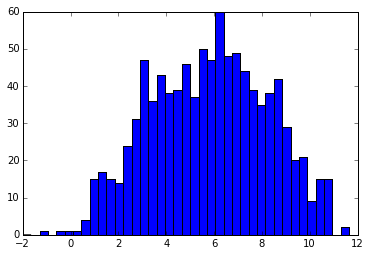

In [630]:
plt.hist(zip(*bigrams_by_year[0][1])[1], bins=np.arange(-2, 12, 0.35))
plt.show()

In [606]:
graphs[0][1].size(), graphs[0][1].order()

(7256, 2300)

In [644]:
graphs = []
centralities = []
for year, bigrams in bigrams_by_year:
    # Each one-year selection of the corpus is represented
    #  with a separate undirected graph.
    graph = nx.Graph()
    for gram, score in bigrams:
        # The threshold here is somewhat arbitrary.
        if score > 0. and gram[0] != gram[1]:   # Prevent self-loops.
            graph.add_edge(*gram, weight=score)
            
    centrality = nx.closeness_centrality(graph, normalized=True)#, weight='weight')

    graphs.append((year, graph))
    centralities.append((year, centrality))    
    
    print '\r', year,     

2013


In [666]:
systems_years = []
systems_values = []
for i, row in df[df.model == 'systems-oriented'].iterrows():
    these_years = []
    these_values = []
    for year, centrality in centralities:

        try:
            these_values.append(centrality[row.term])#, 0.0))
            these_years.append(year)            
        except KeyError:
            pass

    try:        
        if np.array(these_values).max() > 0:      
            systems_years.append(np.array(these_years))
            systems_values.append(np.array(these_values))    
    except ValueError:
        pass
    
neutral_years = []
neutral_values = []
for i, row in df[df.model == 'neutral'].iterrows():
    these_years = []
    these_values = []
    for year, centrality in centralities:

        try:
            these_values.append(centrality[row.term])#, 0.0))
            these_years.append(year)            
        except KeyError:
            pass

    try:        
        if np.array(these_values).max() > 0:         
            neutral_years.append(np.array(these_years))
            neutral_values.append(np.array(these_values)) 
    except ValueError:
        pass
    
biology_years = []
biology_values = []
for i, row in df[df.model == 'biology-oriented'].iterrows():
    these_years = []
    these_values = []
    for year, centrality in centralities:

        try:
            these_values.append(centrality[row.term])#, 0.0))
            these_years.append(year)
        except KeyError:
            pass
    try:        
        if np.array(these_values).max() > 0:    
            biology_years.append(np.array(these_years))
            biology_values.append(np.array(these_values)) 
    except ValueError:
        pass

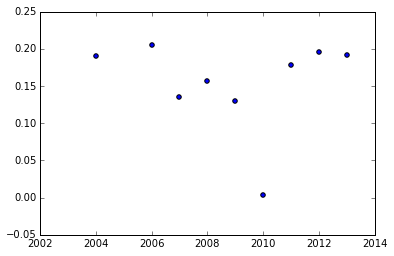

In [668]:
plt.scatter(biology_years[2], biology_values[2])

In [329]:
import pymc

In [346]:
systems_values[5].shape

(11,)

In [527]:
def make_model(systems_data, neutral_data, biology_data):
    systems_X, systems_Y = systems_data    
    neutral_X, neutral_Y = neutral_data
    biology_X, biology_Y = biology_data

    beta_systems = pymc.Uniform('beta_systems', -10., 10., value=0.01)
    beta_neutral = pymc.Uniform('beta_neutral', -10., 10., value=0.01)
    beta_biology = pymc.Uniform('beta_biology', -10., 10., value=0.01)

    beta0_systems = pymc.Uniform('beta0_systems', -15., 25., value=1.)
    beta0_neutral = pymc.Uniform('beta0_neutral', -15., 15., value=0.01)
    beta0_biology = pymc.Uniform('beta0_biology', -15., 15., value=0.01)
    
    response_systems = pymc.Container([pymc.Poisson('response_systems_%i' % i, 
                                        mu=beta_systems*(systems_X[i]-systems_X[i].min()+1.) + beta0_systems, 
                                        value=1000.*systems_Y[i], observed=True)
                        for i in xrange(len(systems_X))])
    response_neutral = pymc.Container([pymc.Poisson('response_neutral_%i' % i, 
                                        mu=beta_neutral*(neutral_X[i]-neutral_X[i].min()+1.) + beta0_neutral, 
                                        value=1000.*neutral_Y[i], observed=True)
                        for i in xrange(len(neutral_X))])
    response_biology = pymc.Container([pymc.Poisson('response_biology_%i' % i, 
                                        mu=beta_biology*(biology_X[i]-biology_X[i].min()+1.) + beta0_biology, 
                                        value=1000.*biology_Y[i], observed=True)
                        for i in xrange(len(biology_X))])    
    
    return locals()

In [ ]:
def make_model(systems_data, neutral_data, biology_data):
    systems_X, systems_Y = systems_data    
    neutral_X, neutral_Y = neutral_data
    biology_X, biology_Y = biology_data

    beta_systems = pymc.Normal('beta_systems', -10., 10., value=0.01)
    beta_neutral = pymc.Normal('beta_neutral', -10., 10., value=0.01)
    beta_biology = pymc.Normal('beta_biology', -10., 10., value=0.01)

    beta0_systems = pymc.Normal('beta0_systems', -15., 25., value=1.)
    beta0_neutral = pymc.Normal('beta0_neutral', -15., 15., value=0.01)
    beta0_biology = pymc.Normal('beta0_biology', -15., 15., value=0.01)
    
    response_systems = pymc.Container([pymc.Poisson('response_systems_%i' % i, 
                                        mu=beta_systems*(systems_X[i]-systems_X[i].min()+1.) + beta0_systems, 
                                        value=1000.*systems_Y[i], observed=True)
                        for i in xrange(len(systems_X))])
    response_neutral = pymc.Container([pymc.Poisson('response_neutral_%i' % i, 
                                        mu=beta_neutral*(neutral_X[i]-neutral_X[i].min()+1.) + beta0_neutral, 
                                        value=1000.*neutral_Y[i], observed=True)
                        for i in xrange(len(neutral_X))])
    response_biology = pymc.Container([pymc.Normal('response_biology_%i' % i, 
                                        mu=beta_biology*(biology_X[i]-biology_X[i].min()+1.) + beta0_biology, 
                                        value=1000.*biology_Y[i], observed=True)
                        for i in xrange(len(biology_X))])    
    
    return locals()

In [669]:
M = pymc.MCMC(make_model((systems_years, systems_values), 
                         (neutral_years, neutral_values), 
                         (biology_years, biology_values)), 
              db='pickle',
              dbname='systemsbiology2.pickle')

In [670]:
M.sample(10000, burn=3000, thin=50)

 [-----------------100%-----------------] 10000 of 10000 complete in 63.7 sec

In [538]:
M.db.close()

In [671]:
systems_beta = M.beta_systems.trace()[:].mean()
systems_beta0 = M.beta0_systems.trace()[:].mean()

neutral_beta = M.beta_neutral.trace()[:].mean()
neutral_beta0 = M.beta0_neutral.trace()[:].mean()

biology_beta = M.beta_biology.trace()[:].mean()
biology_beta0 = M.beta0_biology.trace()[:].mean()

In [672]:
systems_model = lambda x: (systems_beta*(x-x.min()+1.) + sytems_beta0)/1000.
neutral_model = lambda x: (neutral_beta*(x-x.min()+1.) + neutral_beta0)/1000.
biology_model = lambda x: (biology_beta*(x-x.min()+1.) + biology_beta0)/1000.

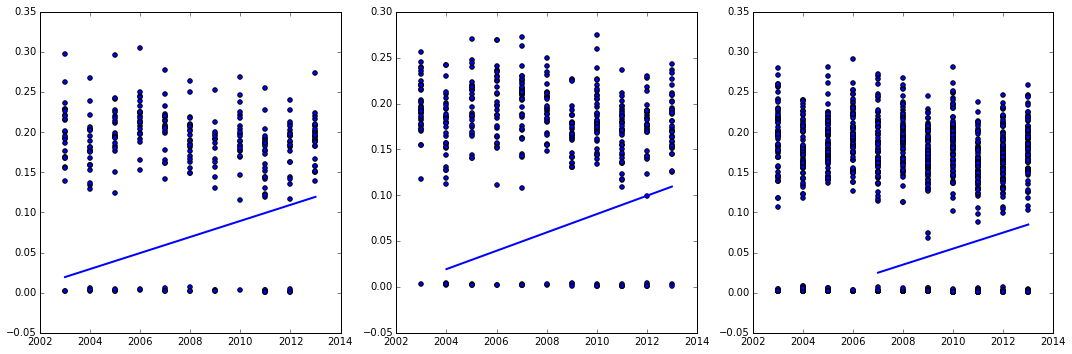

In [675]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
[plt.scatter(systems_years[i], systems_values[i]) for i in xrange(len(systems_values)) if systems_values[i].max() > 0]
plt.plot(systems_years[0], systems_model(systems_years[0]), lw=2)
# plt.yscale('log')

plt.subplot(132)
[plt.scatter(neutral_years[i], neutral_values[i]) for i in xrange(len(neutral_values)) if neutral_values[i].max() > 0]
plt.plot(neutral_years[0], systems_model(neutral_years[0]), lw=2)
# plt.yscale('log')

plt.subplot(133)
[plt.scatter(biology_years[i], biology_values[i]) for i in xrange(len(biology_values)) if biology_values[i].max() > 0]
plt.plot(biology_years[0], biology_model(biology_years[0]), lw=2)
# plt.yscale('log')

plt.tight_layout()
plt.show()

Plotting beta_neutral
Plotting beta_biology
Plotting beta0_neutral
Plotting beta0_systems
Plotting beta_systems
Plotting beta0_biology


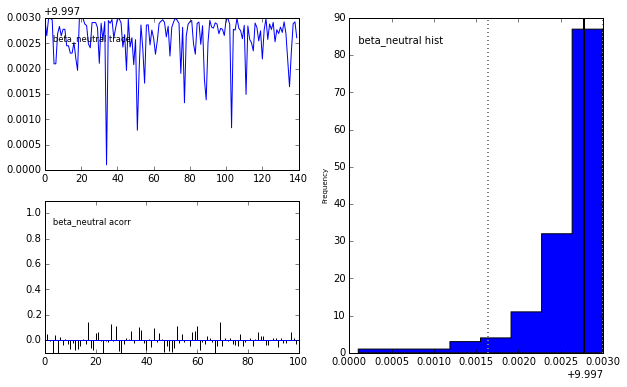

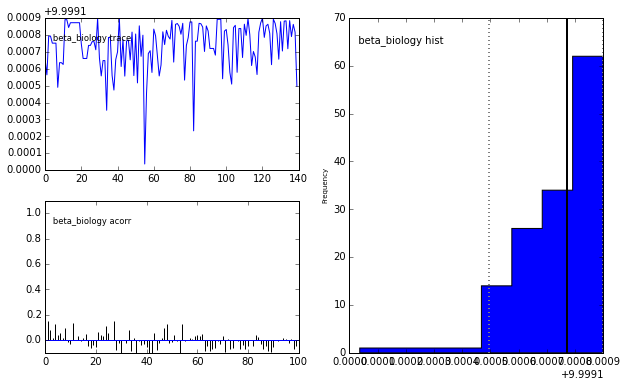

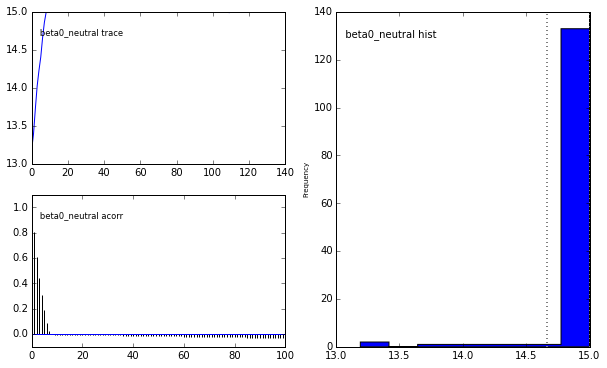

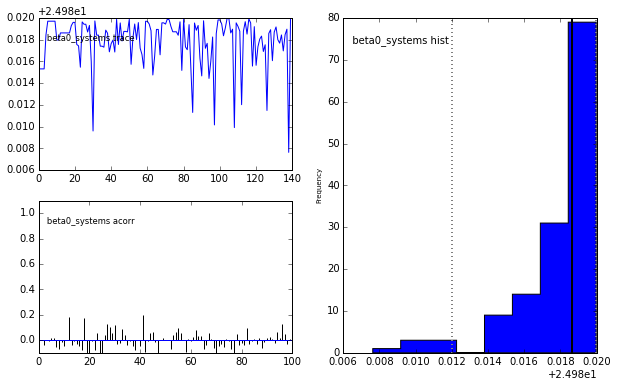

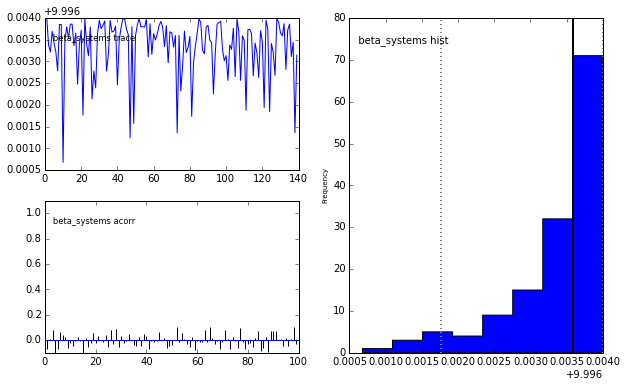

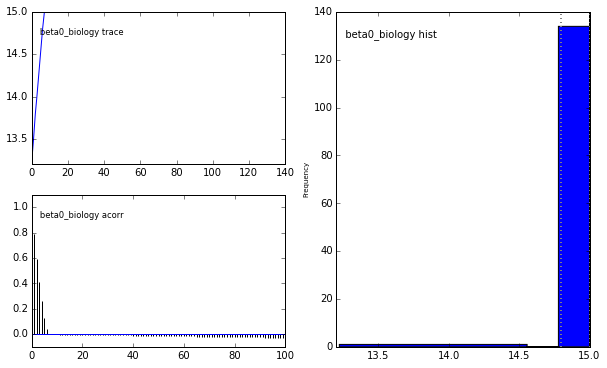

In [676]:
pymc.Matplot.plot(M)

## Sentences

## Documents

In [35]:
df

,model,term
0,neutral,production
1,biology-oriented,oxidative
2,biology-oriented,therapy
3,biology-oriented,ms
4,biology-oriented,infection
5,biology-oriented,microscopy
6,biology-oriented,vaccine
7,neutral,correlation
8,biology-oriented,synthetic
9,biology-oriented,omics
